See [fast_wcs_interp_torch_experiments_part2](fast_wcs_interp_torch_experiments_part2.ipynb) for previous part

In [1]:
from pathlib import Path
import itertools

import numpy as np

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy import constants

from specutils import Spectrum1D
from specutils.manipulation import FluxConservingResampler


from jwst import datamodels

%matplotlib inline
from matplotlib import pyplot as plt

from tqdm.notebook import tqdm

In [23]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.pipeline import make_pipeline

# Data loading

In [3]:
slit_name = 's00066'

redux_path = Path(f'data/jwst_outputs/redux_{slit_name}/')

In [4]:
cal_paths = list(redux_path.glob('*cal.fits'))
cal_paths

[PosixPath('data/jwst_outputs/redux_s00066/jw02609010001_03101_00002_nrs2_cal.fits'),
 PosixPath('data/jwst_outputs/redux_s00066/jw02609010001_03101_00001_nrs1_cal.fits'),
 PosixPath('data/jwst_outputs/redux_s00066/jw02609010001_03101_00002_nrs1_cal.fits'),
 PosixPath('data/jwst_outputs/redux_s00066/jw02609010001_03101_00001_nrs2_cal.fits')]

In [5]:
cal_dms = {p.name: datamodels.open(p) for p in tqdm(cal_paths) if 'jw02609010001_03101_00002_nrs2_cal' in p.name}
cal_dms

  0%|          | 0/4 [00:00<?, ?it/s]

{'jw02609010001_03101_00002_nrs2_cal.fits': <MultiSlitModel from jw02609010001_03101_00002_nrs2_cal.fits>}

In [6]:
slit_all = {}
for k, dm in cal_dms.items():
    matches = np.array([s.source_id for s in dm.slits]) == 42
    assert np.sum(matches)==1
    idx = np.where(matches)[0][0]

    slit_all[k] = dm.slits[idx]

In [7]:
slit = slit_all['jw02609010001_03101_00002_nrs2_cal.fits']

In [8]:
#phoenix_model = fits.open('ftp://phoenix.astro.physik.uni-goettingen.de/HiResFITS/PHOENIX-ACES-AGSS-COND-2011/Z+0.5/lte04700-3.00+0.5.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits', cache=True)
phoenix_model = fits.open('phoenix/lte04700-3.00+0.5.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits')
#phoenix_wave = fits.getdata('ftp://phoenix.astro.physik.uni-goettingen.de/HiResFITS//WAVE_PHOENIX-ACES-AGSS-COND-2011.fits', cache=True)*u.angstrom
phoenix_wave = fits.getdata('phoenix/WAVE_PHOENIX-ACES-AGSS-COND-2011.fits')*u.angstrom

phoenix_spec = Spectrum1D(spectral_axis=phoenix_wave, flux=phoenix_model[0].data*u.Unit(phoenix_model[0].header['BUNIT']))

2024-04-05 03:46:30,595 - stpipe - WARNING - UnitsWarning: 'erg/s/cm^2/cm' contains multiple slashes, which is discouraged by the FITS standard


In [9]:
wls = np.quantile(slit.wavelength[np.isfinite(slit.wavelength)], [0, .5,1])*u.micron

msk = (wls[0] <= phoenix_spec.spectral_axis) & (phoenix_spec.spectral_axis<=wls[-1])

phoenix_sub_spec = Spectrum1D(spectral_axis=phoenix_spec.spectral_axis[msk], 
                                        flux=phoenix_spec.flux[msk])

In [10]:
dmodel = np.diff(phoenix_sub_spec.spectral_axis)

phoenix_lowres_wls_dlamb = np.max(dmodel)*10
phoenix_lowres_wl_bins = np.arange(wls[0].to(phoenix_lowres_wls_dlamb.unit).value, 
                                   wls[-1].to(phoenix_lowres_wls_dlamb.unit).value, 
                                   phoenix_lowres_wls_dlamb.to(phoenix_lowres_wls_dlamb.unit).value)*phoenix_lowres_wls_dlamb.unit

phoenix_lowres = FluxConservingResampler().resample1d(phoenix_sub_spec, 
                            (phoenix_lowres_wl_bins[:-1] + phoenix_lowres_wl_bins[1:])/2)

len(phoenix_lowres.spectral_axis)/slit.data.shape[1]  # tells how much better sampled the "low" res spectrum is from the data

11.77783203125

### Cuda/torch preliminaries

In [11]:
import os
#os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
#os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, Dataset

In [12]:
for nm in 'cpu,cuda,cudnn,mps,mkl,mkldnn,openmp'.split(','):
    be = getattr(torch.backends, nm)
    built = be.is_built() if hasattr(be, 'is_built') else None
    avail = be.is_available() if hasattr(be, 'is_available') else None
    if avail is None and nm == 'cuda':
        avail = torch.cuda.is_available()
    print(nm, built, avail) 

torch_device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {torch_device} device")

cpu None None
cuda True True
cudnn None True
mps False False
mkl None True
mkldnn None True
openmp None True
Using cuda device


In [13]:
primary_datatype = torch.float32
def dconvert(x):
    cons = torch.from_numpy if isinstance(x, np.ndarray) else torch.Tensor
    return cons(x).to(torch_device, dtype=primary_datatype)

In [14]:
param_simplers = 'lambda,raoff,decoff'.split(',')
lptp = np.ptp(phoenix_lowres.spectral_axis)
lmin = np.min(phoenix_lowres.spectral_axis)
def ptrans_3feature(urand):
    l = lptp*urand[0] + lmin
    ro = (urand[1]*2 - 1)
    do = (urand[2]*2 - 1)
    
    return l,ro << u.arcsec,do << u.arcsec

base_sc = SkyCoord(slit.source_ra<<u.deg, slit.source_dec<<u.deg)
def make_batch_3feature(rng, batch_size):
    l, ro, do = ptrans_3feature(rng.random(size=(len(param_simplers), batch_size)))
    l0 = l

    sc = base_sc.spherical_offsets_by(ro, do)
    
    outs = np.array(slit.meta.wcs.world_to_pixel(sc, l0))
    ins = np.array([l.value, ro.value, do.value])

    return dconvert(ins).T, dconvert(outs).T

[t.shape for t in make_batch_3feature(np.random.default_rng(), 100)]

[torch.Size([100, 3]), torch.Size([100, 2])]

In [15]:
def make_grid_3feature(sizes, flatten=False):
    mingrids = ptrans_3feature([0 for _ in sizes])
    maxgrids = ptrans_3feature([1 for _ in sizes])
    mgrids = [np.linspace(*e) for e in zip(mingrids, maxgrids, sizes)]
    l, ro, do = np.meshgrid(*mgrids)

    sc = base_sc.spherical_offsets_by(ro, do)
    outs = dconvert(slit.meta.wcs.world_to_pixel(sc, l))

    ins = dconvert((l.value, ro.value, do.value))

    ins = ins.permute(*np.roll(range(len(ins.shape)), -1))
    outs = outs.permute(*np.roll(range(len(outs.shape)), -1))

    if flatten:
        ins = ins.reshape(ins.shape.numel()//ins.shape[-1], ins.shape[-1])
        outs = outs.reshape(outs.shape.numel()//outs.shape[-1], outs.shape[-1])
    
    return ins, outs

valid_ins, valid_outs = make_grid_3feature((100,100,100))
valid_ins_plot, valid_outs_plot = make_grid_3feature((100,10,10), flatten=True)
valid_ins.shape, valid_ins_plot.shape, valid_ins.shape, valid_outs_plot.shape

/tmp/ipykernel_70/3779681214.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  return cons(x).to(torch_device, dtype=primary_datatype)


(torch.Size([100, 100, 100, 3]),
 torch.Size([10000, 3]),
 torch.Size([100, 100, 100, 3]),
 torch.Size([10000, 2]))

# Training Functions

In [16]:
def batch_train_resample(model, batch_size, n_batches, npregen, log_period=500, seed=42, optimizer=None, loss_fcn=None, 
                         valid_ins=valid_ins, valid_outs=valid_outs, perm=True, 
                         lrsched=None, verbose=True):
    """pregen is a number of samples.  must be larger than n_batches, and each batch will sample a random permutation."""
    assert (npregen == 'valid') or (batch_size <= npregen)
    model = model.to(torch_device)
    
    if isinstance(seed, np.random.Generator):
        rng = seed
    else:
        rng = np.random.default_rng(seed)
        
    if loss_fcn is None:
        loss_fcn = nn.MSELoss().to(torch_device, dtype=torch.float32)
    if optimizer is None:
        optimizer = torch.optim.Adam(model.parameters())
    elif isinstance(optimizer, dict):
        optimizer = torch.optim.Adam(model.parameters(), **optimizer)
    if lrsched is not None:
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, **lrsched)
        llr = 0

    if npregen == 'valid':
        ins = valid_ins.reshape((valid_ins.shape.numel()//valid_ins.shape[-1], valid_ins.shape[-1]))
        outs = valid_outs.reshape((valid_outs.shape.numel()//valid_outs.shape[-1], valid_outs.shape[-1]))
        npregen = ins.shape[0]
    else:
        ins, outs = make_batch_3feature(rng, npregen)
    idxs = np.arange(npregen)
    
    batchi_test = []
    loss_test = []
    lr_update = []
    model.train()
    
    for batchi in tqdm(list(range(n_batches))):
        if perm:
            rng.shuffle(idxs)
            samples = idxs[:batch_size]
        else:
            samples = rng.integers(npregen, size=batch_size)

        samples_t = torch.from_numpy(samples).to(torch_device)
            
        inb = ins[samples_t]
        outb = outs[samples_t]
            
        pred = model(inb)
        loss = loss_fcn(pred, outb)

        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (log_period is not None and (batchi % log_period == 0)) or batchi == (n_batches-1):
            with torch.no_grad():
                model.eval()
                batchi_test.append(batchi)

                loss_test.append(loss_fcn(model(valid_ins), valid_outs).item())
                if verbose:
                    if verbose == 'r':
                        print('\rtest loss at batch', batchi, 'is', loss_test[-1], end='')
                    else:
                        print('test loss at batch', batchi, 'is', loss_test[-1])
                if lrsched is not None:
                    scheduler.step(loss_test[-1])
                    if llr != scheduler.get_last_lr():
                        llr = scheduler.get_last_lr()
                        if verbose == 'r':
                            print('\r' + ' '*80, end='\r')
                        print('lr updated to', llr, 'at', batchi)
                        lr_update.append(batchi)
            model.train()
        
    model.eval()
    model.batchi_test = batchi_test
    model.loss_test = loss_test
    model.lr_update = lr_update
    return model

In [17]:
def plot_model_run(model, points_to_cut=1, valid_ins=valid_ins, valid_outs=valid_outs):
    batchis = model.batchi_test
    losses = model.loss_test
    lr_update = model.lr_update
    
    fig, (ax1, ax2) = plt.subplots(2,1)
    ax1.scatter(batchis[points_to_cut:], losses[points_to_cut:])
    ax1.axhline(0, color='k', alpha=.5)
    
    ax2.scatter(batchis[points_to_cut:], losses[points_to_cut:])
    ax2.semilogy()

    for upd in lr_update:
        for ax in (ax1, ax2):
            ax.axvline(upd, c='k', ls=':', lw=1)

    return fig

def plot_model_results(model, X=valid_ins_plot, Y=valid_outs_plot, maxpoints=None, **plotkwargs):
    with torch.no_grad():
        pred = model(X)
        diff = (pred - Y).cpu().detach().numpy()

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))

    

    if maxpoints is None:
        slc = slice(None)
    else:
        slc = np.random.permutation(valid_outs_flat.shape[0])[:maxpoints]

    p = pred.cpu().detach().numpy()[slc]
    v = Y.cpu().detach().numpy()[slc]

    plotkwargs.setdefault('marker', 'o')
    plotkwargs.setdefault('linewidth', 0)
    plotkwargs.setdefault('markeredgewidth', 0)
    
    
    ax1.plot(p[:, 0], **plotkwargs, label='pred')
    ax1.plot(v[:, 0], **plotkwargs, label='validation')
    ax1.legend(loc=0)
    ax1.set_ylabel('x')
    
    ax2.plot(p[:, 1], **plotkwargs, label='pred')
    ax2.plot(v[:, 1], **plotkwargs, label='validation')
    ax2.legend(loc=0)
    ax2.set_ylabel('y')
        
    ax3.plot(diff[slc], **plotkwargs)
    ax3.set_ylabel('residuals')
    ax3.legend(['x', 'y'], loc=0)
    
    return fig


# NNs

In [18]:
class RescalingNeuralNetwork(nn.Module):
    def __init__(self, inbounds, outbounds, nneurons=[32, 16], endsmooth=False):
        """
        outbounds should be [(d1lower, d1upper), (d2lower, d2upper), etc...]
        """
        super().__init__()
        self.endsmooth = endsmooth
        assert len(nneurons) >= 1

        in_n = len(inbounds)
        self.inscale = dconvert([u-l for l, u in inbounds])
        self.inoffset = dconvert([l for l, u in inbounds])
        
        out_n = len(outbounds)
        self.outscale = dconvert([u-l for l, u in outbounds])
        self.outoffset = dconvert([l for l, u in outbounds])
        

        stack = [nn.Linear(in_n, nneurons[0]),
                 nn.GELU(),
                 ]
        for n1, n2 in zip(nneurons[:-1], nneurons[1:]):
            stack.append(nn.Linear(n1, n2))
            stack.append(nn.GELU())
        
        self.last_linear = nn.Linear(nneurons[-1], out_n)
        stack.append(self.last_linear)
        
        self.stack = nn.Sequential(*[s for s in stack if s is not None])

    @property
    def in_n(self):
        return self.stack[0].in_features

    @property
    def out_n(self):
        return self.last_linear.out_features
        
    def forward(self, x):
        assert x.shape[-1] == self.in_n
        
        leading_dims = x.shape[:-1]
        xflat = x.reshape(x.shape.numel() // self.in_n, self.in_n)
        xflat_rescaled = (xflat - self.inoffset)/self.inscale
        y = self.stack(xflat_rescaled)
        assert y.shape[-1] == self.out_n
        if self.endsmooth:
            y = torch.atan(y)/torch.pi + .5
        return y.reshape(*leading_dims, self.out_n) * self.outscale + self.outoffset

model = RescalingNeuralNetwork([(0,2), (-1, 2), (3,4)], [(0,2), (-1, 2)], endsmooth=True).to(torch_device)
test_batch_in, test_batch_out = make_batch_3feature(np.random.default_rng(), 100)
model(test_batch_in).shape, test_batch_out.shape, test_batch_in.shape

(torch.Size([100, 2]), torch.Size([100, 2]), torch.Size([100, 3]))

In [22]:
%%time

inscale = [(float(valid_ins[...,i].min()), float(valid_ins[...,i].max())) for i in range(valid_ins.shape[-1])]
outscale = [(float(valid_outs[...,i].min()), float(valid_outs[...,i].max())) for i in range(valid_outs.shape[-1])]
res = batch_train_resample(RescalingNeuralNetwork(inscale, outscale), 
                           1024*15, 100000, log_period=500, npregen=1024*2000, perm=False, 
                           optimizer=dict(lr=1e-3, fused=True), 
                           lrsched={'mode':'min', 'patience':3, 'factor':.3, 'threshold':.001}, verbose=False)

  0%|          | 0/100000 [00:00<?, ?it/s]

lr updated to [0.001] at 0
lr updated to [0.0003] at 12000
lr updated to [8.999999999999999e-05] at 16000
lr updated to [2.6999999999999996e-05] at 30000
lr updated to [8.099999999999999e-06] at 52000
CPU times: user 1min 45s, sys: 6.53 s, total: 1min 52s
Wall time: 1min 50s


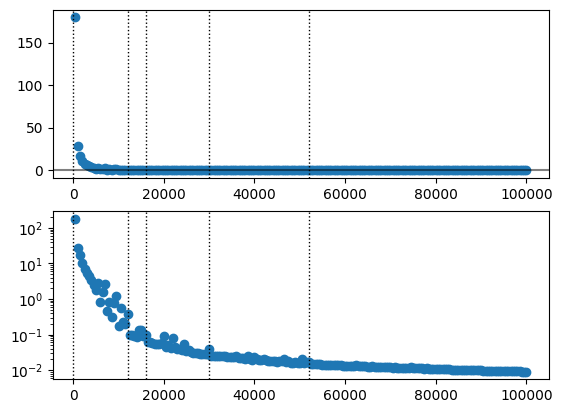

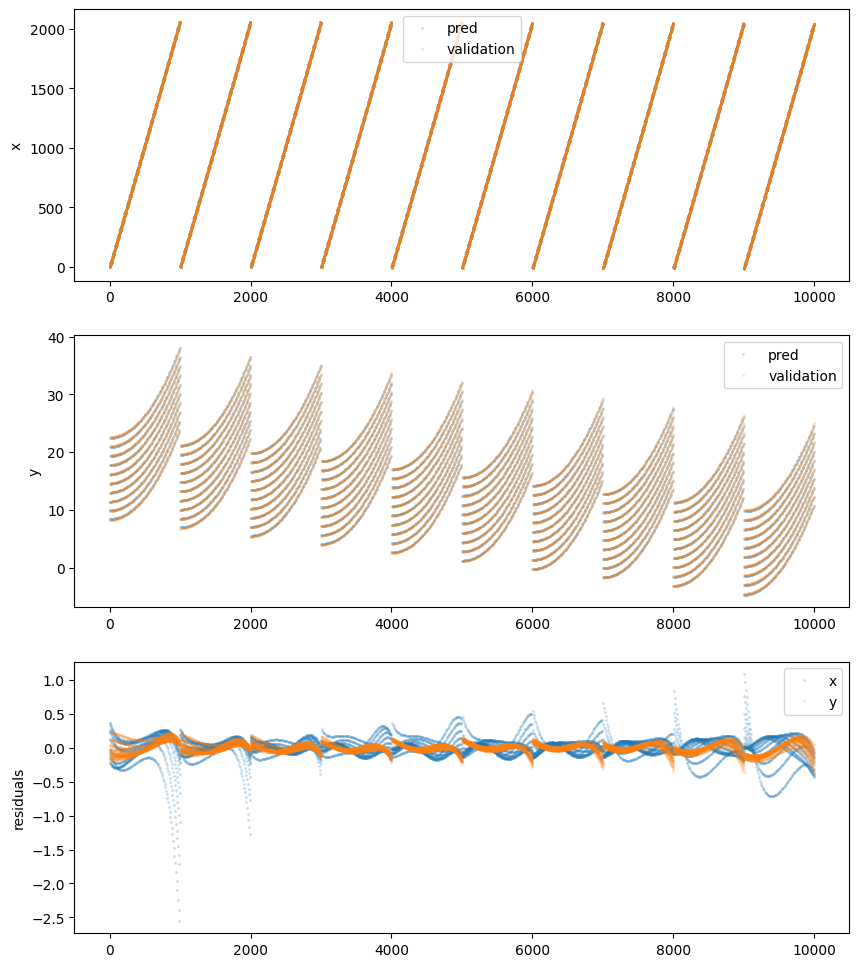

In [23]:
plot_model_run(res)
fig = plot_model_results(res, maxpoints=None, alpha=.25, ms=2)

More neurons?

In [76]:
%%time

inscale = [(float(valid_ins[...,i].min()), float(valid_ins[...,i].max())) for i in range(valid_ins.shape[-1])]
outscale = [(float(valid_outs[...,i].min()), float(valid_outs[...,i].max())) for i in range(valid_outs.shape[-1])]
res = batch_train_resample(RescalingNeuralNetwork(inscale, outscale, first_layer_nneurons=64, inner_layer_nneurons=32), 
                           1024*15, 100000, log_period=250, npregen=1024*200, perm=False, 
                           optimizer=dict(lr=1e-3, fused=True), 
                           lrsched={'mode':'min', 'patience':3, 'factor':.3, 'threshold':.001}, verbose='r')

  0%|          | 0/100000 [00:00<?, ?it/s]

test loss at batch 0 is 185098.140625
lr updated to [0.001] at 0
test loss at batch 9500 is 0.053795810788869864
lr updated to [0.0003] at 9500
test loss at batch 12750 is 0.036651011556386955
lr updated to [8.999999999999999e-05] at 12750
test loss at batch 17250 is 0.031491011381149294
lr updated to [2.6999999999999996e-05] at 17250
test loss at batch 22250 is 0.024475242942571643
lr updated to [8.099999999999999e-06] at 22250
test loss at batch 51500 is 0.010370661504566674
lr updated to [2.4299999999999996e-06] at 51500
test loss at batch 99999 is 0.005712703801691532CPU times: user 2min 22s, sys: 4.21 s, total: 2min 26s
Wall time: 2min 25s


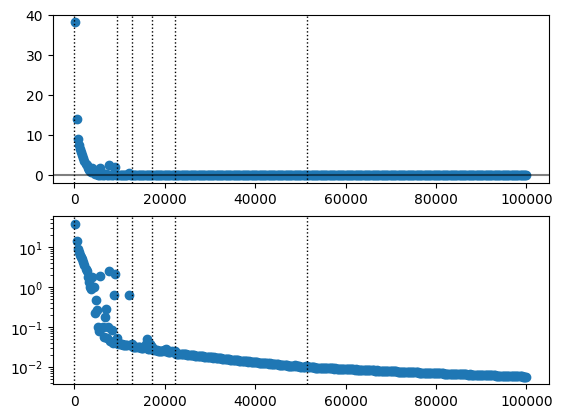

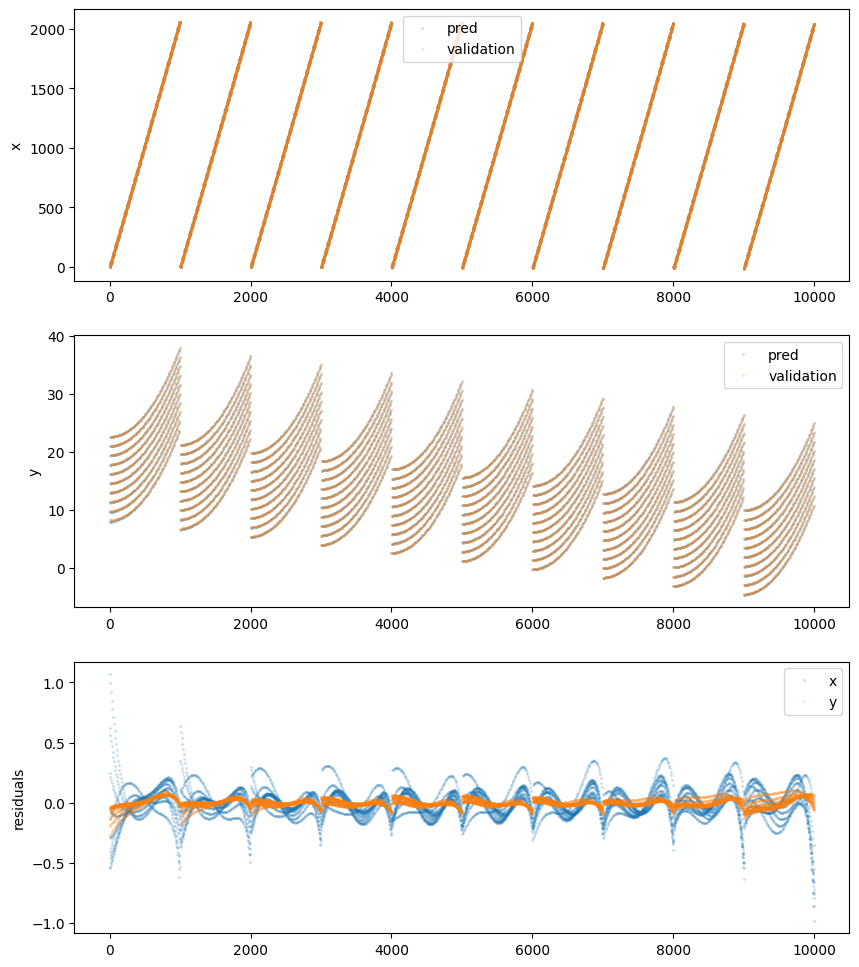

In [77]:
plot_model_run(res)
fig = plot_model_results(res, maxpoints=None, alpha=.25, ms=2)

Arctan at end?

  0%|          | 0/100000 [00:00<?, ?it/s]

lr updated to [0.001] at 03099.40625                                                                                
lr updated to [0.0005] at 3850025210857391357                                                                                
lr updated to [0.00025] at 4150043369674682617                                                                                
lr updated to [0.000125] at 587502592849731445                                                                                
test loss at batch 99999 is 1.5637987852096558CPU times: user 1min 29s, sys: 2.49 s, total: 1min 32s
Wall time: 1min 30s


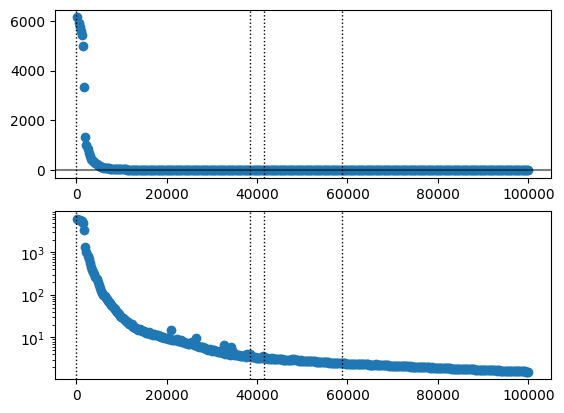

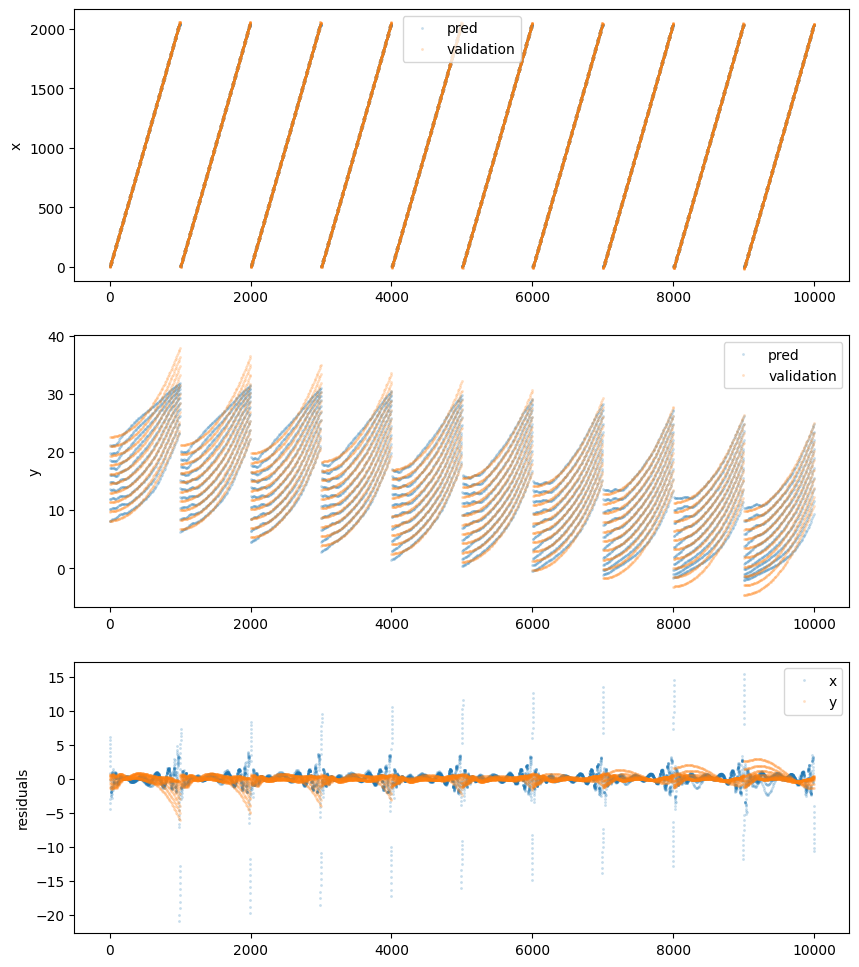

In [100]:
%%time

inscale = [(float(valid_ins[...,i].min()), float(valid_ins[...,i].max())) for i in range(valid_ins.shape[-1])]
outscale = [(float(valid_outs[...,i].min()), float(valid_outs[...,i].max())) for i in range(valid_outs.shape[-1])]
res = batch_train_resample(RescalingNeuralNetwork(inscale, outscale, first_layer_nneurons=32, inner_layer_nneurons=16, endsmooth=True), 
                           1024*15, 100000, log_period=250, npregen=1024*200, perm=False, 
                           optimizer=dict(lr=1e-3, fused=True), 
                           lrsched={'mode':'min', 'patience':3, 'factor':.5, 'threshold':.001}, verbose='r')
plot_model_run(res)
fig = plot_model_results(res, maxpoints=None, alpha=.25, ms=2)

Maybe the random sampling is messing with things by not reaching into the grid?  Lets intead try batching through the grid.

In [104]:
valid_ins.shape.numel()/valid_ins.shape[-1]/1024

976.5625

  0%|          | 0/100000 [00:00<?, ?it/s]

lr updated to [0.001] at 01369.3125                                                                                
lr updated to [0.0005] at 36000467050552368164                                                                                
lr updated to [0.00025] at 417508596887588501                                                                                
lr updated to [0.000125] at 737506716232299805                                                                                
test loss at batch 99999 is 1.1276156902313232CPU times: user 2min 37s, sys: 3.3 s, total: 2min 41s
Wall time: 2min 41s


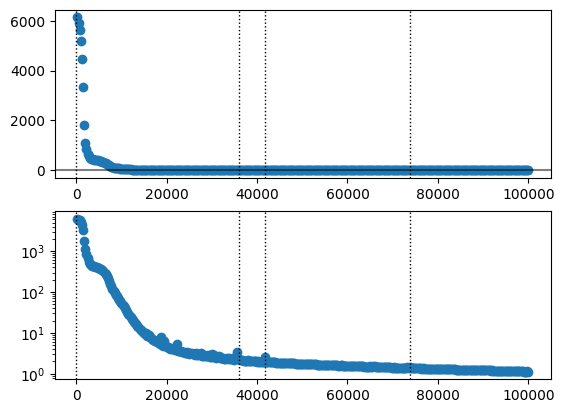

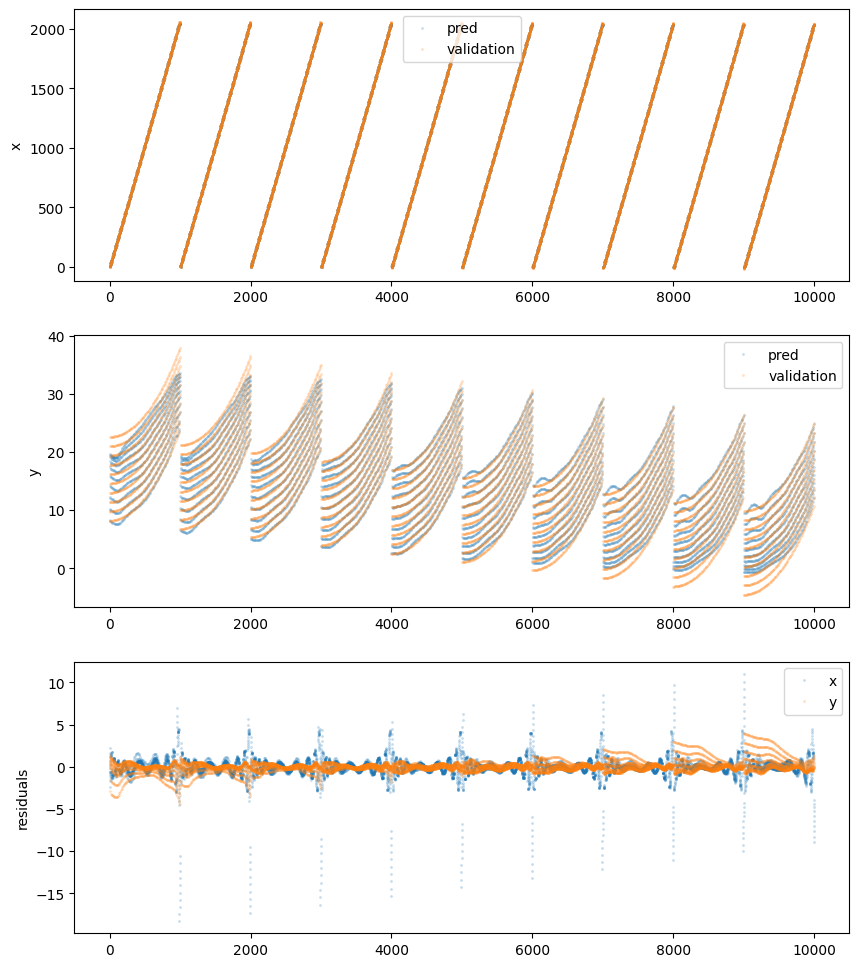

In [119]:
%%time

inscale = [(float(valid_ins[...,i].min()), float(valid_ins[...,i].max())) for i in range(valid_ins.shape[-1])]
outscale = [(float(valid_outs[...,i].min()), float(valid_outs[...,i].max())) for i in range(valid_outs.shape[-1])]
res = batch_train_resample(RescalingNeuralNetwork(inscale, outscale, first_layer_nneurons=32, inner_layer_nneurons=16, endsmooth=True), 
                           1024*25, 100000, log_period=250, npregen='valid', perm=False, 
                           optimizer=dict(lr=1e-3, fused=True), 
                           lrsched={'mode':'min', 'patience':3, 'factor':.5, 'threshold':.001}, verbose='r')
plot_model_run(res)
fig = plot_model_results(res, maxpoints=None, alpha=.25, ms=2)

  0%|          | 0/100000 [00:00<?, ?it/s]

lr updated to [0.001] at 0                                                      
lr updated to [0.0005] at 22000                                                 
lr updated to [0.00025] at 27250                                                
lr updated to [0.000125] at 32500                                               
lr updated to [6.25e-05] at 37750                                               
lr updated to [3.125e-05] at 46750                                              
lr updated to [1.5625e-05] at 59500                                             
lr updated to [7.8125e-06] at 91250                                             
test loss at batch 99999 is 0.0032599885016679764CPU times: user 2min 42s, sys: 2.99 s, total: 2min 45s
Wall time: 2min 44s


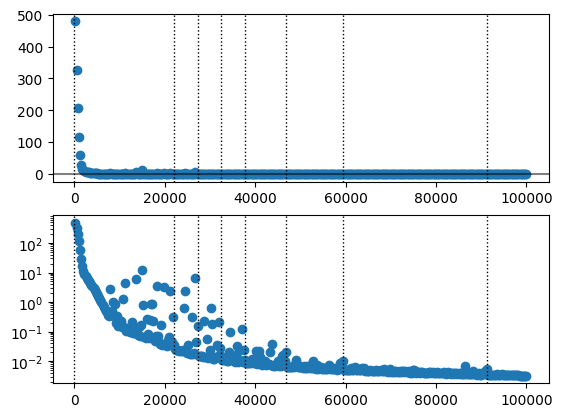

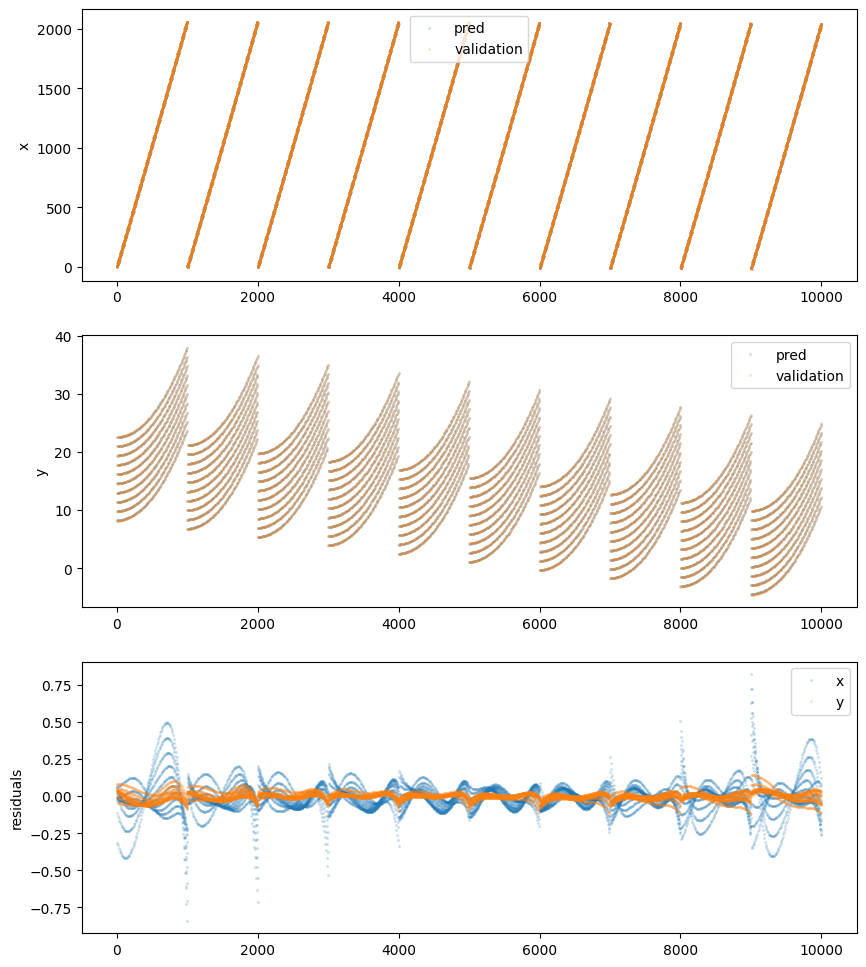

In [135]:
%%time

inscale = [(float(valid_ins[...,i].min()), float(valid_ins[...,i].max())) for i in range(valid_ins.shape[-1])]
outscale = [(float(valid_outs[...,i].min()), float(valid_outs[...,i].max())) for i in range(valid_outs.shape[-1])]
res = batch_train_resample(RescalingNeuralNetwork(inscale, outscale, first_layer_nneurons=32, inner_layer_nneurons=16, endsmooth=False), 
                           1024*50, 100000, log_period=250, npregen='valid', perm=False, 
                           optimizer=dict(lr=1e-3, fused=True), 
                           lrsched={'mode':'min', 'patience':5, 'factor':.5, 'threshold':.001}, verbose='r')
plot_model_run(res)
fig = plot_model_results(res, maxpoints=None, alpha=.25, ms=2)

  0%|          | 0/1000000 [00:00<?, ?it/s]

lr updated to [0.001] at 0                                                      
lr updated to [0.0005] at 12500                                                 
lr updated to [0.00025] at 21500                                                
lr updated to [0.000125] at 27000                                               
lr updated to [6.25e-05] at 29750                                               
lr updated to [3.125e-05] at 33250                                              
lr updated to [1.5625e-05] at 40500                                             
lr updated to [7.8125e-06] at 70500                                             
lr updated to [3.90625e-06] at 137250                                           
lr updated to [1.953125e-06] at 177500                                          
lr updated to [9.765625e-07] at 259250                                          
lr updated to [4.8828125e-07] at 452000                                         
lr updated to [2.44140625e-0

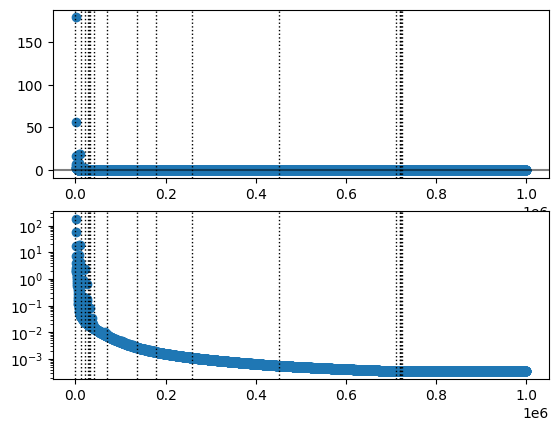

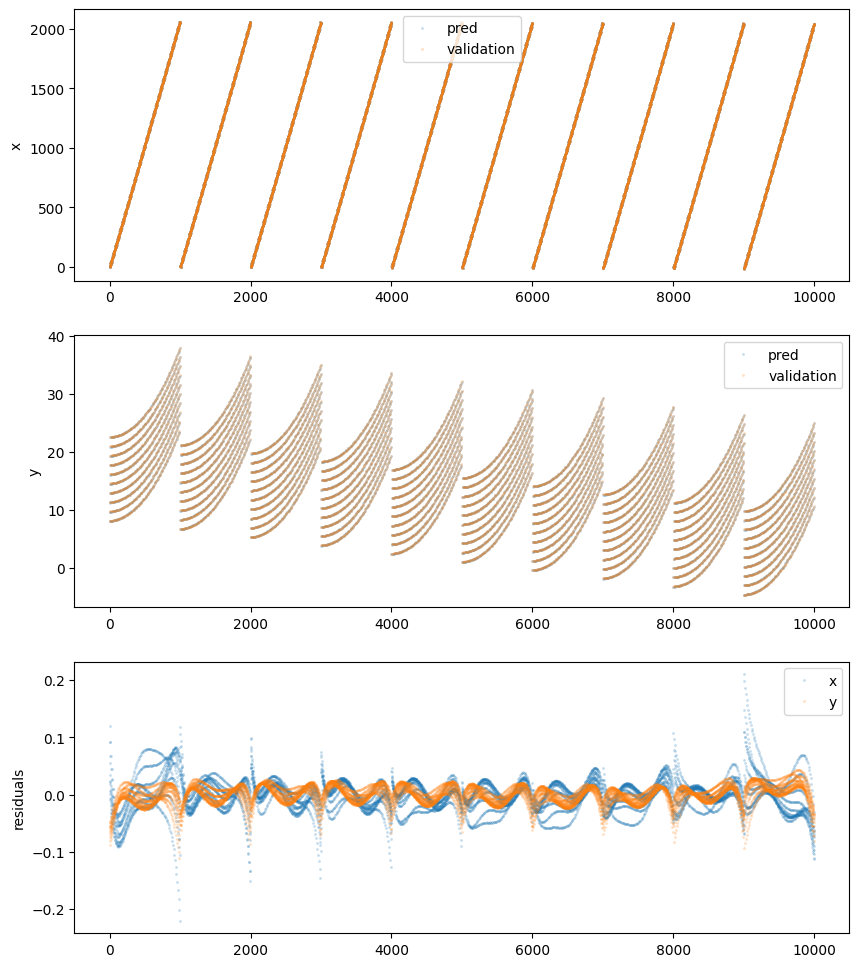

In [137]:
%%time

inscale = [(float(valid_ins[...,i].min()), float(valid_ins[...,i].max())) for i in range(valid_ins.shape[-1])]
outscale = [(float(valid_outs[...,i].min()), float(valid_outs[...,i].max())) for i in range(valid_outs.shape[-1])]
res = batch_train_resample(RescalingNeuralNetwork(inscale, outscale, nneurons=[128,32], endsmooth=False), 
                           1024*50, 1000000, log_period=250, npregen='valid', perm=False, 
                           optimizer=dict(lr=1e-3, fused=True), 
                           lrsched={'mode':'min', 'patience':5, 'factor':.5, 'threshold':.001}, verbose='r')
plot_model_run(res)
fig = plot_model_results(res, maxpoints=None, alpha=.25, ms=2)

Try varying depth but small batches

  0%|          | 0/250000 [00:00<?, ?it/s]

lr updated to [0.001] at 0                                                      
lr updated to [0.0005] at 15000                                                 
lr updated to [0.00025] at 27000                                                
lr updated to [0.000125] at 33000                                               
lr updated to [6.25e-05] at 43250                                               
lr updated to [3.125e-05] at 47500                                              
lr updated to [1.5625e-05] at 61500                                             
lr updated to [7.8125e-06] at 76000                                             
lr updated to [3.90625e-06] at 80750                                            
lr updated to [1.953125e-06] at 97000                                           
lr updated to [9.765625e-07] at 99750                                           
lr updated to [4.8828125e-07] at 102250                                         
lr updated to [2.44140625e-0

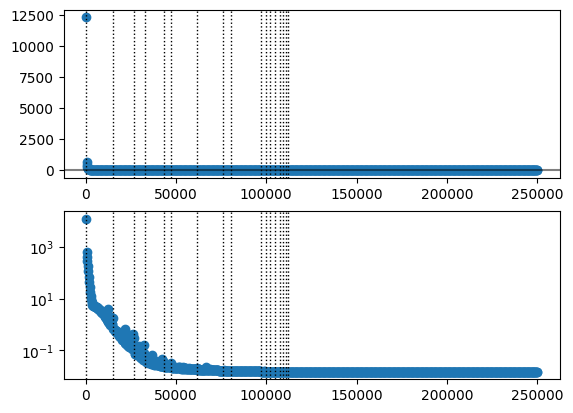

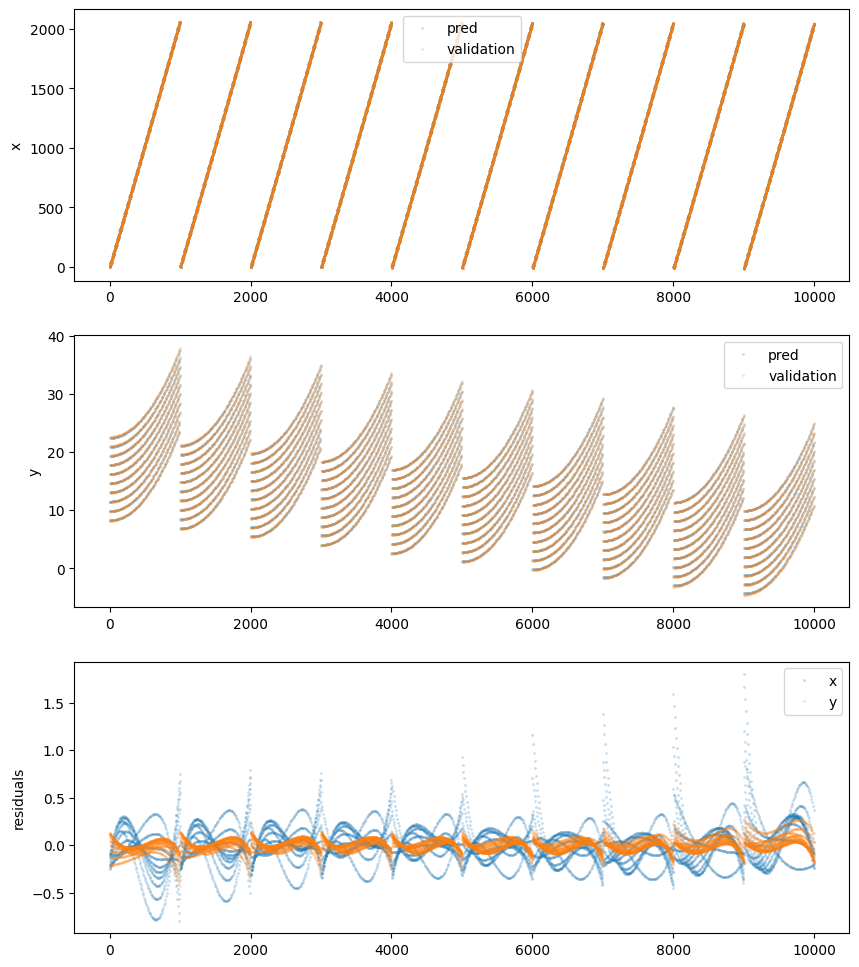

In [141]:
%%time

inscale = [(float(valid_ins[...,i].min()), float(valid_ins[...,i].max())) for i in range(valid_ins.shape[-1])]
outscale = [(float(valid_outs[...,i].min()), float(valid_outs[...,i].max())) for i in range(valid_outs.shape[-1])]
res = batch_train_resample(RescalingNeuralNetwork(inscale, outscale, nneurons=[32], endsmooth=False), 
                           1024, 250000, log_period=250, npregen='valid', perm=False, 
                           optimizer=dict(lr=1e-3, fused=True), 
                           lrsched={'mode':'min', 'patience':5, 'factor':.5, 'threshold':.001}, verbose='r')
plot_model_run(res)
fig = plot_model_results(res, maxpoints=None, alpha=.25, ms=2)

  0%|          | 0/250000 [00:00<?, ?it/s]

lr updated to [0.001] at 0                                                      
lr updated to [0.0002] at 23000                                                 
lr updated to [4e-05] at 47500                                                  
lr updated to [8.000000000000001e-06] at 100000                                 
lr updated to [1.6000000000000004e-06] at 117750                                
lr updated to [3.200000000000001e-07] at 139250                                 
lr updated to [6.400000000000003e-08] at 219000                                 
lr updated to [1.2800000000000007e-08] at 222500                                
lr updated to [2.5600000000000015e-09] at 225750                                
test loss at batch 249999 is 0.008469172753393652CPU times: user 3min 49s, sys: 4.59 s, total: 3min 54s
Wall time: 3min 55s


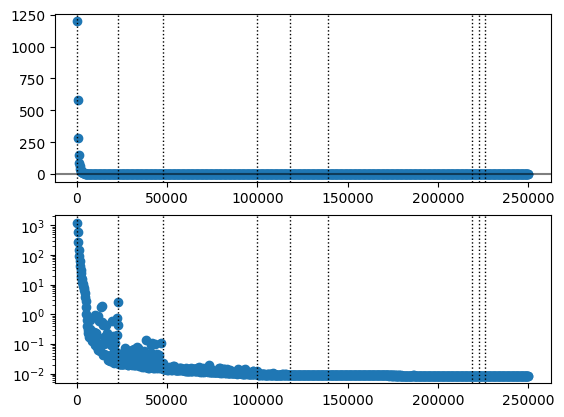

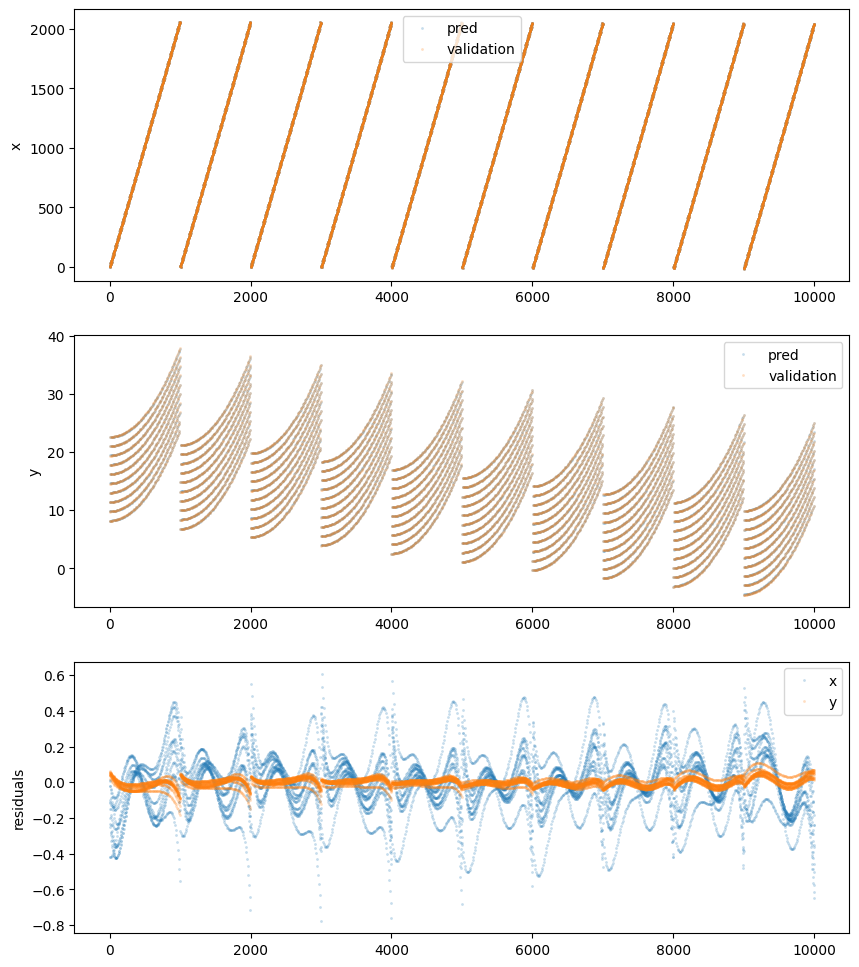

In [144]:
%%time

inscale = [(float(valid_ins[...,i].min()), float(valid_ins[...,i].max())) for i in range(valid_ins.shape[-1])]
outscale = [(float(valid_outs[...,i].min()), float(valid_outs[...,i].max())) for i in range(valid_outs.shape[-1])]
res = batch_train_resample(RescalingNeuralNetwork(inscale, outscale, nneurons=[32,16], endsmooth=False), 
                           1024, 250000, log_period=250, npregen='valid', perm=False, 
                           optimizer=dict(lr=1e-3, fused=True), 
                           lrsched={'mode':'min', 'patience':10, 'factor':.2, 'threshold':.0001}, verbose='r')
plot_model_run(res)
fig = plot_model_results(res, maxpoints=None, alpha=.25, ms=2)

  0%|          | 0/250000 [00:00<?, ?it/s]

lr updated to [0.001] at 0                                                      
lr updated to [0.0003] at 15750                                                 
lr updated to [8.999999999999999e-05] at 43500                                  
lr updated to [2.6999999999999996e-05] at 48000                                 
lr updated to [8.099999999999999e-06] at 120500                                 
lr updated to [2.4299999999999996e-06] at 159500                                
lr updated to [7.289999999999998e-07] at 193500                                 
lr updated to [2.1869999999999994e-07] at 234000                                
test loss at batch 249999 is 0.006657023448497057CPU times: user 5min 39s, sys: 7.15 s, total: 5min 46s
Wall time: 5min 49s


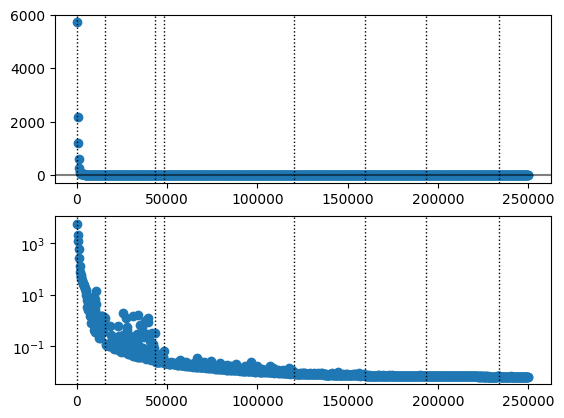

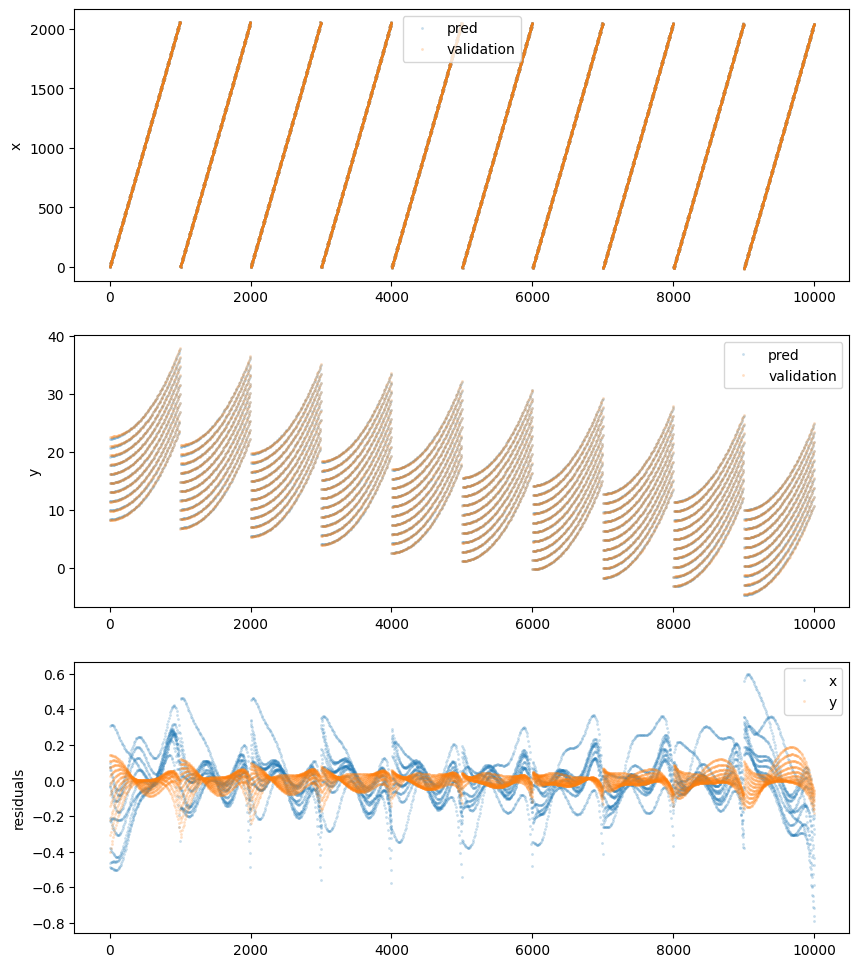

In [145]:
%%time

inscale = [(float(valid_ins[...,i].min()), float(valid_ins[...,i].max())) for i in range(valid_ins.shape[-1])]
outscale = [(float(valid_outs[...,i].min()), float(valid_outs[...,i].max())) for i in range(valid_outs.shape[-1])]
res = batch_train_resample(RescalingNeuralNetwork(inscale, outscale, nneurons=[16,16,16,16], endsmooth=False), 
                           1024, 250000, log_period=250, npregen='valid', perm=False, 
                           optimizer=dict(lr=1e-3, fused=True), 
                           lrsched={'mode':'min', 'patience':10, 'factor':.3, 'threshold':.0001}, verbose='r')
plot_model_run(res)
fig = plot_model_results(res, maxpoints=None, alpha=.25, ms=2)

  0%|          | 0/250000 [00:00<?, ?it/s]

lr updated to [0.001] at 0                                                      
lr updated to [0.0003] at 24250                                                 
lr updated to [8.999999999999999e-05] at 47250                                  
lr updated to [2.6999999999999996e-05] at 67750                                 
lr updated to [8.099999999999999e-06] at 82500                                  
lr updated to [2.4299999999999996e-06] at 179250                                
test loss at batch 249999 is 0.0011556537356227636CPU times: user 6min 11s, sys: 6.44 s, total: 6min 17s
Wall time: 6min 18s


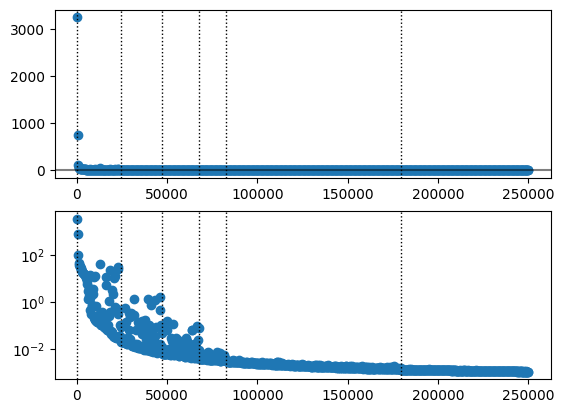

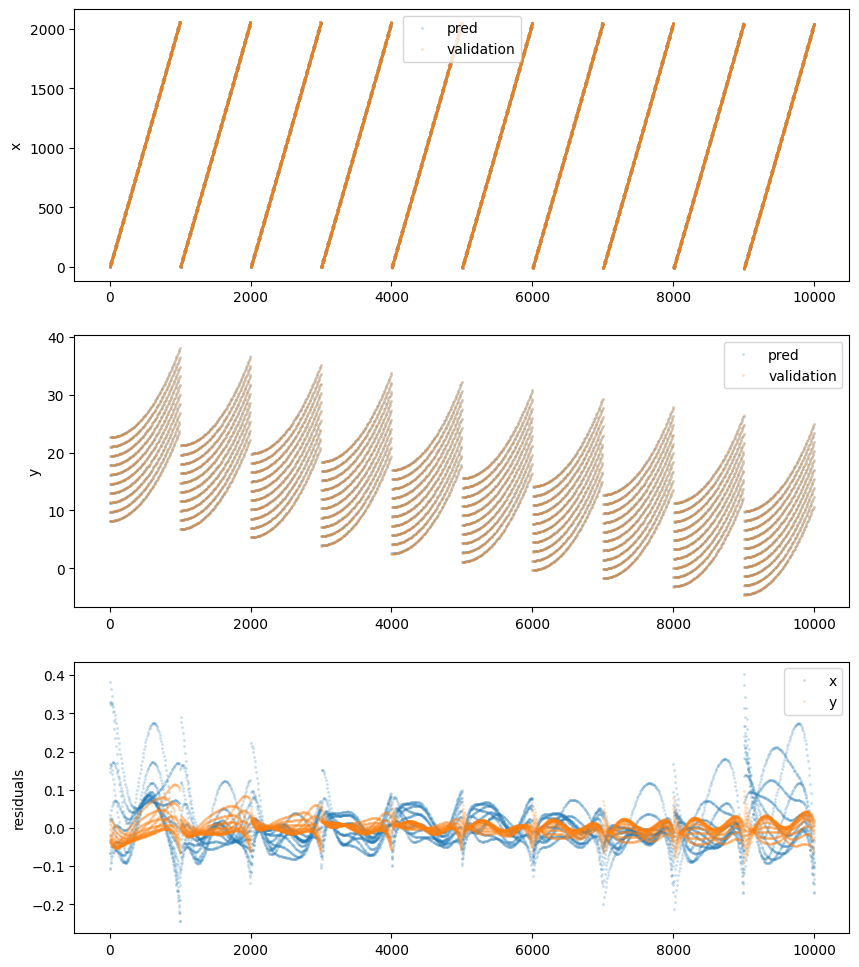

In [146]:
%%time

inscale = [(float(valid_ins[...,i].min()), float(valid_ins[...,i].max())) for i in range(valid_ins.shape[-1])]
outscale = [(float(valid_outs[...,i].min()), float(valid_outs[...,i].max())) for i in range(valid_outs.shape[-1])]
res = batch_train_resample(RescalingNeuralNetwork(inscale, outscale, nneurons=[16,16,16,16], endsmooth=False), 
                           1024*16, 250000, log_period=250, npregen='valid', perm=False, 
                           optimizer=dict(lr=1e-3, fused=True), 
                           lrsched={'mode':'min', 'patience':10, 'factor':.3, 'threshold':.0001}, verbose='r')
plot_model_run(res)
fig = plot_model_results(res, maxpoints=None, alpha=.25, ms=2)

  0%|          | 0/250000 [00:00<?, ?it/s]

lr updated to [0.001] at 0                                                      
lr updated to [0.0003] at 27750                                                 
lr updated to [8.999999999999999e-05] at 55750                                  
lr updated to [2.6999999999999996e-05] at 60500                                 
lr updated to [8.099999999999999e-06] at 65500                                  
lr updated to [2.4299999999999996e-06] at 112500                                
lr updated to [7.289999999999998e-07] at 178750                                 
test loss at batch 249999 is 0.000583556538913399CPU times: user 6min 19s, sys: 6.72 s, total: 6min 26s
Wall time: 6min 27s


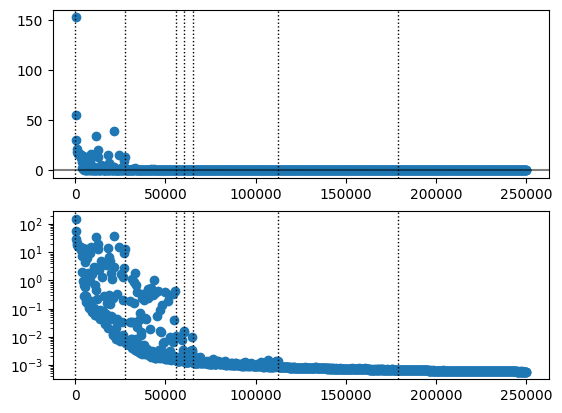

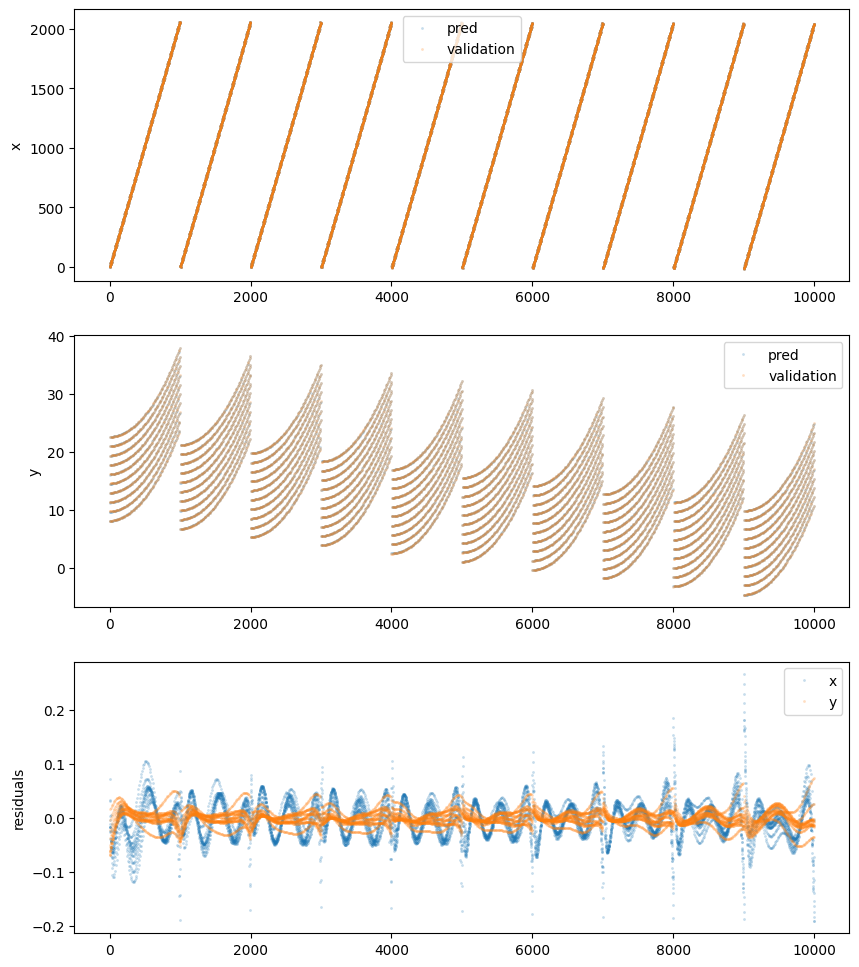

In [147]:
%%time

inscale = [(float(valid_ins[...,i].min()), float(valid_ins[...,i].max())) for i in range(valid_ins.shape[-1])]
outscale = [(float(valid_outs[...,i].min()), float(valid_outs[...,i].max())) for i in range(valid_outs.shape[-1])]
res = batch_train_resample(RescalingNeuralNetwork(inscale, outscale, nneurons=[64,32,16,16], endsmooth=False), 
                           1024*16, 250000, log_period=250, npregen='valid', perm=False, 
                           optimizer=dict(lr=1e-3, fused=True), 
                           lrsched={'mode':'min', 'patience':10, 'factor':.3, 'threshold':.0001}, verbose='r')
plot_model_run(res)
fig = plot_model_results(res, maxpoints=None, alpha=.25, ms=2)

## Now try direct polynomial fitting

In [102]:
flatins = valid_ins.reshape(valid_ins.shape.numel()//valid_ins.shape[-1], valid_ins.shape[-1])
flatouts = valid_outs.reshape(valid_outs.shape.numel()//valid_outs.shape[-1], valid_outs.shape[-1])
msk = np.random.permutation(flatins.shape[0])[:1024]
subins = flatins[msk]
subouts = flatouts[msk]

/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=2.14254e-30): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


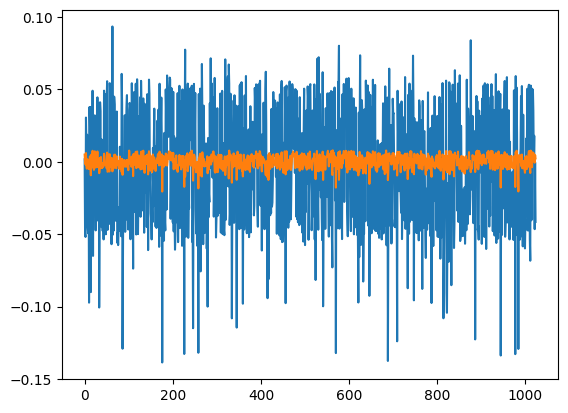

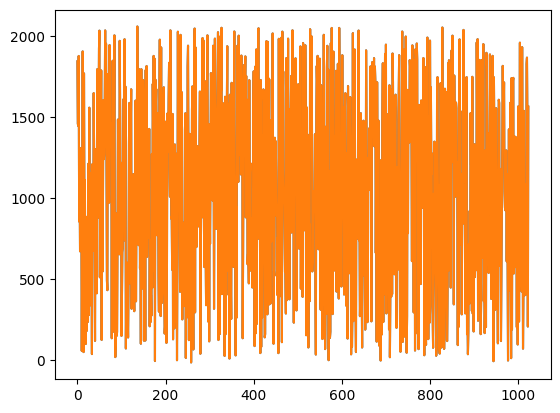

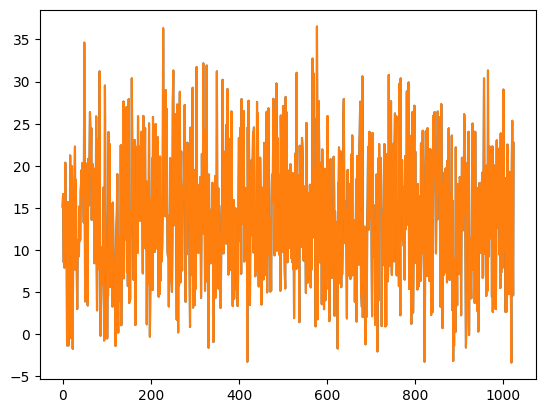

In [123]:
deg = 3
skmodel = make_pipeline(PolynomialFeatures(deg), Ridge(alpha=1e-3))

x = subins.cpu().numpy()
y = subouts.cpu().numpy()
skmodel.fit(x, y)

pf = skmodel.steps[0][-1]
fit = skmodel.steps[1][-1]

plt.figure()
plt.plot(skmodel.predict(x)-y)

plt.figure()
plt.plot(skmodel.predict(x)[:,0])
plt.plot(y[:,0])
plt.figure()
plt.plot(skmodel.predict(x)[:,1])
plt.plot(y[:,1]);

In [127]:
pf.get_feature_names_out()

array(['1', 'x0', 'x1', 'x2', 'x0^2', 'x0 x1', 'x0 x2', 'x1^2', 'x1 x2',
       'x2^2', 'x0^3', 'x0^2 x1', 'x0^2 x2', 'x0 x1^2', 'x0 x1 x2',
       'x0 x2^2', 'x1^3', 'x1^2 x2', 'x1 x2^2', 'x2^3'], dtype=object)

In [129]:
pf.transform(x).shape

(1024, 20)

In [130]:
pf.transform(x)

array([[ 1.00000000e+00,  1.44750791e+04, -1.11111112e-01, ...,
        -1.18468646e-02, -1.02313831e-01, -8.83619428e-01],
       [ 1.00000000e+00,  1.35979883e+04,  1.71717167e-01, ...,
         3.87200201e-03,  2.96094269e-03,  2.26425030e-03],
       [ 1.00000000e+00,  1.35492607e+04,  1.91919193e-01, ...,
        -3.46006751e-02,  1.69361189e-01, -8.28978479e-01],
       ...,
       [ 1.00000000e+00,  1.35979883e+04,  8.18181813e-01, ...,
         3.58377159e-01,  2.34493703e-01,  1.53434157e-01],
       [ 1.00000000e+00,  1.06256240e+04, -9.09090936e-02, ...,
        -5.92703931e-03, -4.67577539e-02, -3.68866712e-01],
       [ 1.00000000e+00,  1.38416240e+04, -2.12121218e-01, ...,
         2.13614590e-02, -4.78089787e-02,  1.07001044e-01]], dtype=float32)

Order matches, so we cat use them to x-chcek if need be

In [22]:
r = torch.rand(1, 3, 6,) 
p = torch.ones(2, 3, 1)
p[1, :] = 2
t = r** p
t, r, p, r**2, t.shape

(tensor([[[0.8734, 0.7731, 0.4968, 0.8329, 0.6490, 0.6607],
          [0.1997, 0.1713, 0.7751, 0.3015, 0.6906, 0.8664],
          [0.1569, 0.6183, 0.5393, 0.2476, 0.7881, 0.4493]],
 
         [[0.7628, 0.5976, 0.2468, 0.6937, 0.4212, 0.4365],
          [0.0399, 0.0293, 0.6008, 0.0909, 0.4770, 0.7507],
          [0.0246, 0.3823, 0.2908, 0.0613, 0.6211, 0.2019]]]),
 tensor([[[0.8734, 0.7731, 0.4968, 0.8329, 0.6490, 0.6607],
          [0.1997, 0.1713, 0.7751, 0.3015, 0.6906, 0.8664],
          [0.1569, 0.6183, 0.5393, 0.2476, 0.7881, 0.4493]]]),
 tensor([[[1.],
          [1.],
          [1.]],
 
         [[2.],
          [2.],
          [2.]]]),
 tensor([[[0.7628, 0.5976, 0.2468, 0.6937, 0.4212, 0.4365],
          [0.0399, 0.0293, 0.6008, 0.0909, 0.4770, 0.7507],
          [0.0246, 0.3823, 0.2908, 0.0613, 0.6211, 0.2019]]]),
 torch.Size([2, 3, 6]))

Above shows how to do the power broadcasting

In [131]:
class PurePolyNeuralNetwork(nn.Module):
    def __init__(self, polydeg, in_n, out_n):
        super().__init__()
        self.polypwrs = torch.from_numpy(make_power_array(polydeg, in_n)[..., np.newaxis].T).to(torch_device, dtype=torch.float32)

        # no bias because one of the features is already the biad - pwr 0
        self.coeffs_layer = nn.Linear(self.polypwrs.shape[-1], out_n, bias=False)
        #self.coeffs_layer.weight = nn.Parameter(torch.ones_like(self.coeffs_layer.weight))

    def x_to_poly(self, x):
        xt = x[...,np.newaxis]
        xp = xt**self.polypwrs
        return torch.prod(xp, 1)

    def set_weights_for_lstsq_solution(self, x, y):
        assert len(x.shape)==2
        assert len(y.shape)==2
        xp = self.x_to_poly(x)
        soln = torch.linalg.lstsq(xp ,y).solution
        self.coeffs_layer.weight = nn.Parameter(soln.T).to(torch_device, dtype=torch.float32)
        return soln

    def forward(self, x):
        leading = list(x.shape[:-1])
        x = x.reshape(x.shape.numel()//x.shape[-1], x.shape[-1])
        xp = self.x_to_poly(x)
        y = self.coeffs_layer(xp)
        dims = leading + [y.shape[-1]]
        return y.reshape(*dims)

model = PurePolyNeuralNetwork(3, 3, 2).to(torch_device)
test_batch_in, test_batch_out = make_batch_3feature(np.random.default_rng(), 100)
model(test_batch_in).shape, test_batch_out.shape, test_batch_in.shape

(torch.Size([100, 2]), torch.Size([100, 2]), torch.Size([100, 3]))

Does this match sk?

In [136]:
xp = model.x_to_poly(subins)
xp.shape

torch.Size([1024, 20])

In [149]:
(xp.cpu().numpy() - pf.transform(x))[1]

array([ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  2.6214400e+05, -2.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  2.3283064e-10],
      dtype=float32)

In [151]:
x[1], xp.cpu().numpy()[1], pf.transform(x)[1]

(array([1.3597988e+04, 1.7171717e-01, 1.3131313e-01], dtype=float32),
 array([1.0000000e+00, 1.3597988e+04, 1.7171717e-01, 1.3131313e-01,
        1.8490528e+08, 2.3350081e+03, 1.7855944e+03, 2.9486785e-02,
        2.2548718e-02, 1.7243138e-02, 2.5143400e+12, 3.1751410e+07,
        2.4280492e+07, 4.0096097e+02, 3.0661722e+02, 2.3447198e+02,
        5.0633871e-03, 3.8720020e-03, 2.9609427e-03, 2.2642505e-03],
       dtype=float32),
 array([1.0000000e+00, 1.3597988e+04, 1.7171717e-01, 1.3131313e-01,
        1.8490528e+08, 2.3350081e+03, 1.7855944e+03, 2.9486785e-02,
        2.2548718e-02, 1.7243138e-02, 2.5143398e+12, 3.1751412e+07,
        2.4280492e+07, 4.0096097e+02, 3.0661722e+02, 2.3447198e+02,
        5.0633871e-03, 3.8720020e-03, 2.9609427e-03, 2.2642503e-03],
       dtype=float32))

Oh my.  Some of these go quickly nuts due to numerical scale differences.  I guess the thing to do is to rescale to (0,1) or so?

In [294]:
def make_power_array(degree, nfeaturesin):
    combs = [(),]
    for i in range(degree):
        combs.extend(itertools.combinations_with_replacement(range(nfeaturesin), i+1))
    pwr = np.zeros((len(combs), nfeaturesin))
    for i in range(len(combs)):
        for j in combs[i]:
            pwr[i, j] += 1
    return pwr

class RescalingPolyModel(nn.Module):
    def __init__(self, inbounds, outbounds, polydeg, in_n, out_n):
        super().__init__()
        self.in_n = in_n
        self.out_n = out_n

        in_n = len(inbounds)
        self.inscale = dconvert([u-l for l, u in inbounds])
        self.inoffset = dconvert([l for l, u in inbounds])
        
        out_n = len(outbounds)
        self.outscale = dconvert([u-l for l, u in outbounds])
        self.outoffset = dconvert([l for l, u in outbounds])
        
        self.polypwrs = torch.from_numpy(make_power_array(polydeg, in_n)[..., np.newaxis].T).to(torch_device, dtype=torch.float32)

        # no bias because one of the features is already the bias - pwr 0
        self.coeffs_layer = nn.Linear(self.polypwrs.shape[-1], out_n, bias=False)

    def set_coeffs_from_leastsq(self, xs, ys):            
        soln = torch.linalg.lstsq(self.x_to_poly(self.inrescale(xs)), (ys - self.outoffset)/self.outscale)
        self.coeffs_layer.weight = nn.Parameter(torch.Tensor(soln.solution.T))
        return soln

    def x_to_poly(self, x):
        xt = x[...,np.newaxis]
        xp = xt**self.polypwrs
        return torch.prod(xp, 1)

    def inrescale(self, x):
        return (x - self.inoffset)/self.inscale

    def outrescale(self, y):
        return y * self.outscale + self.outoffset

    def forward(self, x):
        assert x.shape[-1] == self.in_n
        
        leading_dims = x.shape[:-1]
        xflat = x.reshape(x.shape.numel() // self.in_n, self.in_n)
        xflat_rescaled = self.inrescale(xflat) 
        
        xp = self.x_to_poly(xflat_rescaled)
        y = self.coeffs_layer(xp)
        
        return self.outrescale(y.reshape(*leading_dims, self.out_n))


model = RescalingPolyModel([(0,2), (-1, 2), (3,4)], [(0,2), (-1, 2)], 3, 3, 2).to(torch_device)
test_batch_in, test_batch_out = make_batch_3feature(np.random.default_rng(), 100)
model(test_batch_in).shape, test_batch_out.shape, test_batch_in.shape

(torch.Size([100, 2]), torch.Size([100, 2]), torch.Size([100, 3]))

  0%|          | 0/50000 [00:00<?, ?it/s]

lr updated to [0.001] at 0                                                      
lr updated to [0.0003] at 22250                                                 
lr updated to [8.999999999999999e-05] at 25500                                  
lr updated to [2.6999999999999996e-05] at 29250                                 
lr updated to [8.099999999999999e-06] at 33000                                  
lr updated to [2.4299999999999996e-06] at 35750                                 
lr updated to [7.289999999999998e-07] at 38500                                  
lr updated to [2.1869999999999994e-07] at 41250                                 
lr updated to [6.560999999999998e-08] at 44000                                  
lr updated to [1.9682999999999992e-08] at 46750                                 
lr updated to [5.904899999999998e-09] at 49500                                  
test loss at batch 49999 is 8.546832395950332e-05CPU times: user 37.4 s, sys: 2.15 s, total: 39.5 s
Wall time

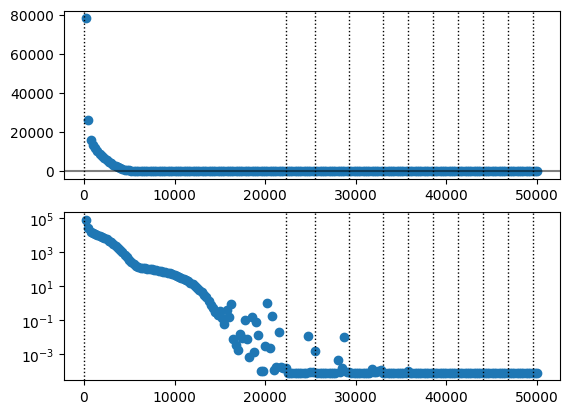

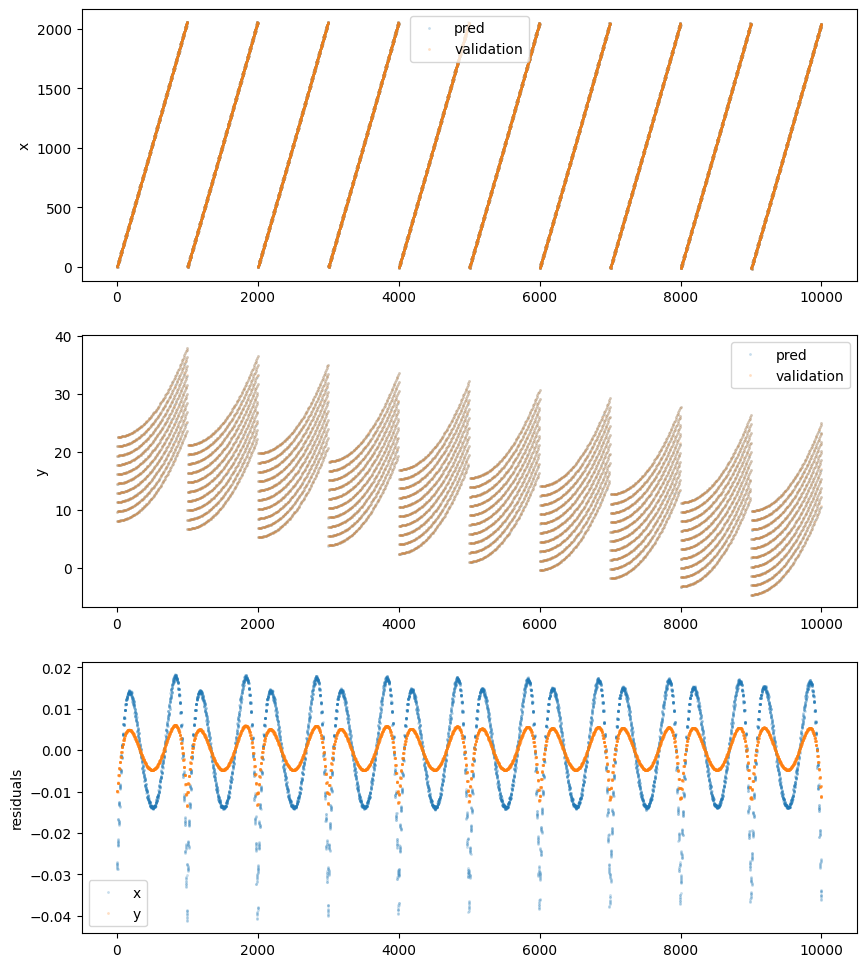

In [358]:
%%time

inscale = [(float(valid_ins[...,i].min()), float(valid_ins[...,i].max())) for i in range(valid_ins.shape[-1])]
outscale = [(float(valid_outs[...,i].min()), float(valid_outs[...,i].max())) for i in range(valid_outs.shape[-1])]
res = batch_train_resample(RescalingPolyModel(inscale, outscale, 3, 3, 2),
                           1024*16, 50000, log_period=250, npregen='valid', perm=False, 
                           optimizer=dict(lr=1e-3, fused=True), 
                           lrsched={'mode':'min', 'patience':10, 'factor':.3, 'threshold':.0001}, verbose='r')
plot_model_run(res)
fig = plot_model_results(res, maxpoints=None, alpha=.25, ms=2)
model3 = res

Higher degree

  0%|          | 0/250000 [00:00<?, ?it/s]

lr updated to [0.003] at 0                                                      
lr updated to [0.0009] at 14500                                                 
lr updated to [0.00027] at 19000                                                
lr updated to [8.1e-05] at 40250                                                
lr updated to [2.43e-05] at 69750                                               
lr updated to [7.29e-06] at 127250                                              
lr updated to [2.187e-06] at 173500                                             
lr updated to [6.561e-07] at 202000                                             
lr updated to [1.9682999999999997e-07] at 247000                                
test loss at batch 249999 is 1.3536513279177598e-06CPU times: user 3min 7s, sys: 10.5 s, total: 3min 17s
Wall time: 3min 18s


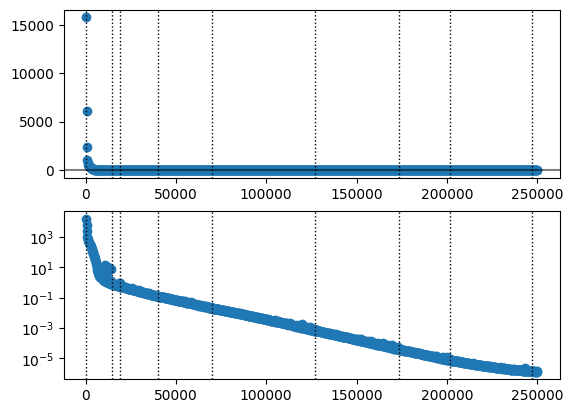

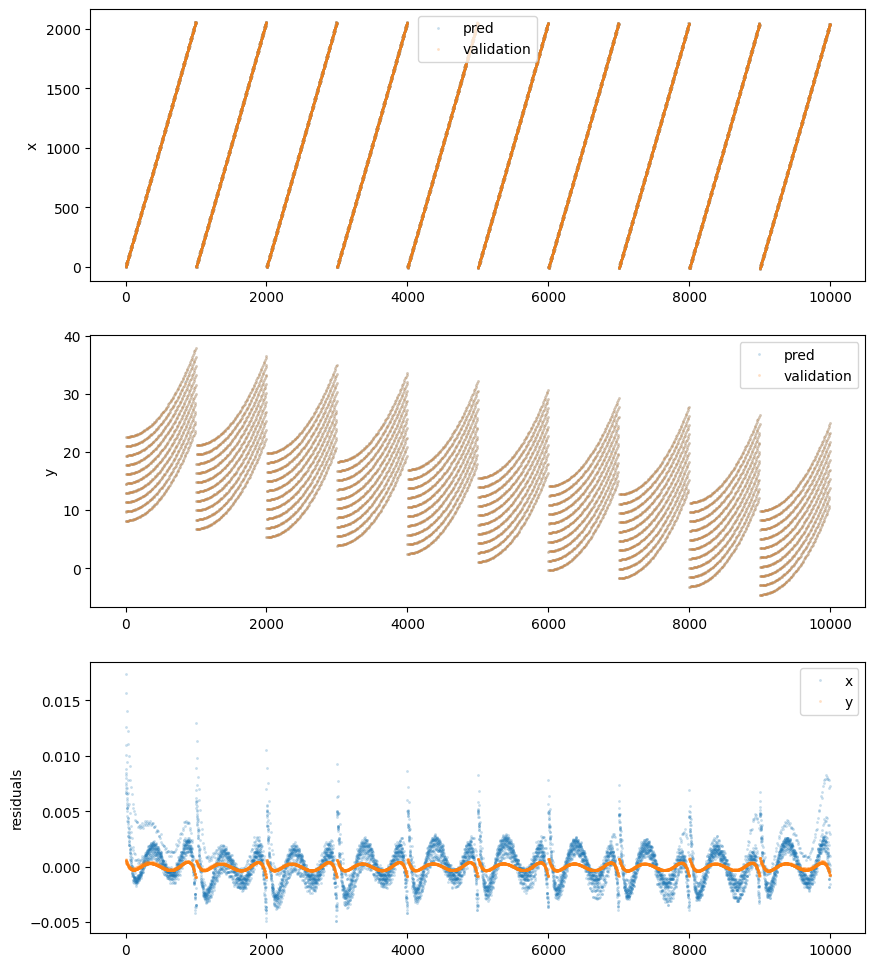

In [356]:
%%time

inscale = [(float(valid_ins[...,i].min()), float(valid_ins[...,i].max())) for i in range(valid_ins.shape[-1])]
outscale = [(float(valid_outs[...,i].min()), float(valid_outs[...,i].max())) for i in range(valid_outs.shape[-1])]
res = batch_train_resample(RescalingPolyModel(inscale, outscale, 4, 3, 2),
                           1024*16, 250000, log_period=250, npregen='valid', perm=False, 
                           optimizer=dict(lr=3e-3, fused=True), 
                           lrsched={'mode':'min', 'patience':3, 'factor':.3, 'threshold':.001}, verbose='r')
plot_model_run(res)
fig = plot_model_results(res, maxpoints=None, alpha=.25, ms=2)

### try initializing with a leastsq solution

  0%|          | 0/30000 [00:00<?, ?it/s]

lr updated to [1e-05] at 0                                                      
lr updated to [2.0000000000000003e-06] at 800                                   
lr updated to [4.000000000000001e-07] at 1600                                   
lr updated to [8.000000000000003e-08] at 2200                                   
lr updated to [1.6000000000000008e-08] at 2800                                  
lr updated to [3.2000000000000018e-09] at 3400                                  
test loss at batch 29999 is 9.629337682781625e-07

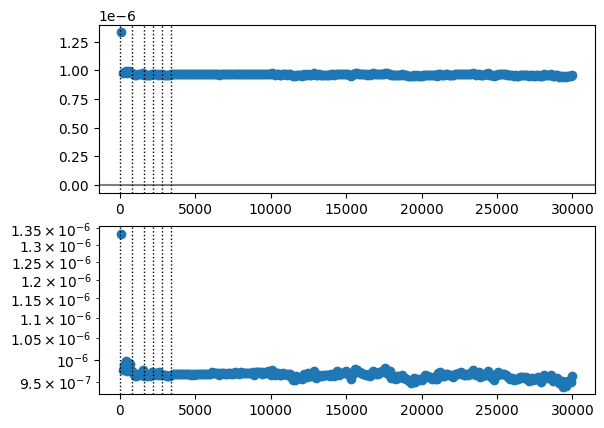

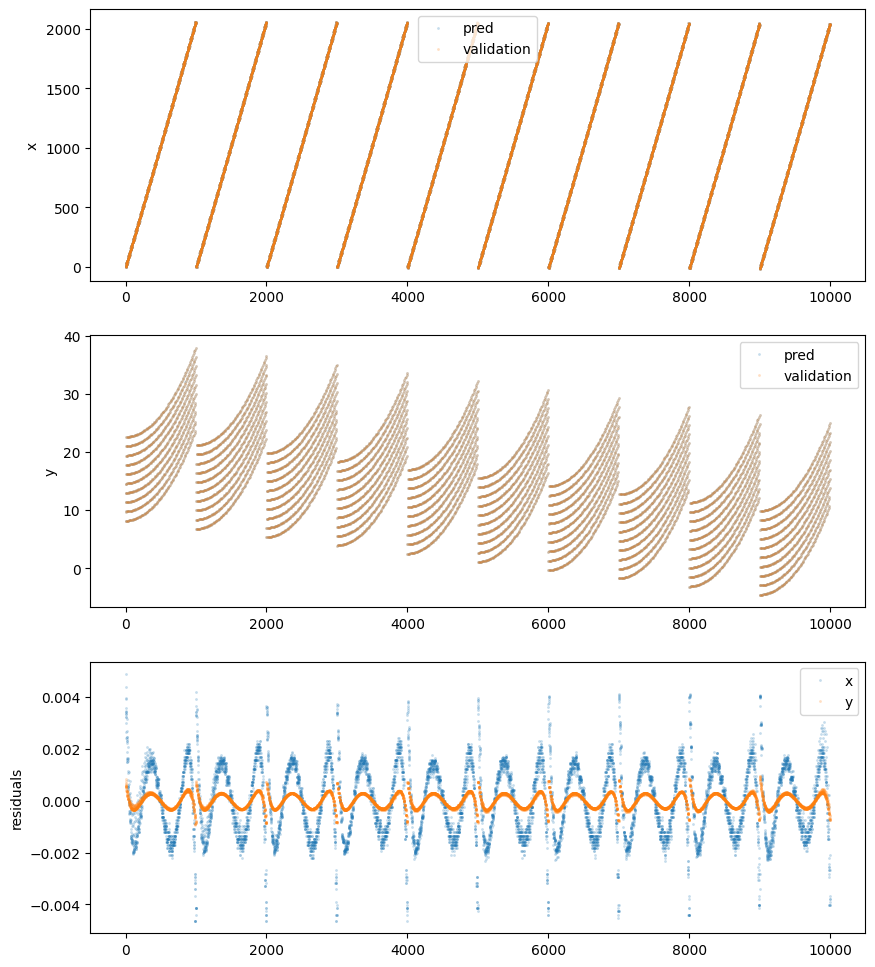

In [308]:
inscale = [(float(valid_ins[...,i].min()), float(valid_ins[...,i].max())) for i in range(valid_ins.shape[-1])]
outscale = [(float(valid_outs[...,i].min()), float(valid_outs[...,i].max())) for i in range(valid_outs.shape[-1])]

model = RescalingPolyModel(inscale, outscale, 4, 3, 2).to(torch_device, dtype=torch.float32)
model.set_coeffs_from_leastsq(subins, subouts)

res = batch_train_resample(model,
                           1024*16, 30000, log_period=100, npregen='valid', perm=False, 
                           optimizer=dict(lr=1e-5, fused=False), 
                           lrsched={'mode':'min', 'patience':5, 'factor':.2, 'threshold':.01}, verbose='r')
plot_model_run(res)
fig = plot_model_results(res, maxpoints=None, alpha=.25, ms=2)

Probably hit numerical precision limits here. Now try some timing tests.

In [309]:
model(subins)

tensor([[1843.8290,   15.1613],
        [1459.3085,   16.6446],
        [1444.9633,    8.6115],
        ...,
        [1451.7021,   15.3686],
        [ 208.1483,    4.6346],
        [1564.3065,   22.7274]], device='cuda:0', grad_fn=<AddBackward0>)

In [355]:
fi = valid_ins.reshape(valid_ins.shape.numel()//valid_ins.shape[-1], valid_ins.shape[-1])
test_in = fi[torch.randperm(fi.shape[0])[:(2048*30)]]

start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

model.eval()

with torch.no_grad():
    start.record()
    test_out = model(test_in)
    end.record()
    torch.cuda.synchronize()

start.elapsed_time(end) #ms

0.35123199224472046

In [359]:
fi = valid_ins.reshape(valid_ins.shape.numel()//valid_ins.shape[-1], valid_ins.shape[-1])
test_in = fi[torch.randperm(fi.shape[0])[:(2048*30)]]

start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

model.eval()

with torch.no_grad():
    start.record()
    test_out = model3(test_in)
    end.record()
    torch.cuda.synchronize()

start.elapsed_time(end) #ms

0.3491840064525604

1/3 of a ms will do the job! And it doesn't really seem to matter deg 3 or deg 4.